In [8]:
%pylab inline

from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

from soln.dataset import get_augmented_train_and_test_set
from soln.dataset import get_component_info_df
from soln.dataset import load_raw_components

pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [9]:
comp_types, group_dfs, cluster_dfs = load_raw_components()
straight = group_dfs['straight']
for feat in ('groove', 'unique_feature', 'orientation'):
    straight[feat] = (straight[feat] == 'Yes')
straight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 12 columns):
component_id         361 non-null object
component_type_id    361 non-null object
bolt_pattern_long    291 non-null float64
bolt_pattern_wide    204 non-null float64
head_diameter        70 non-null float64
overall_length       41 non-null float64
thickness            361 non-null float64
mj_class_code        120 non-null object
groove               361 non-null bool
unique_feature       361 non-null bool
orientation          361 non-null bool
weight               354 non-null float64
dtypes: bool(3), float64(6), object(3)
memory usage: 29.3+ KB


In [10]:
# Convert mj_class_code to binary features.
straight.mj_class_code.fillna('MJ-other', inplace=True)
print straight.mj_class_code.value_counts()
lb = LabelBinarizer()
bin_feats = lb.fit_transform(straight.mj_class_code.values)
print lb.classes_
tmp_df = pd.DataFrame(bin_feats, columns=lb.classes_)
straight = straight.join(tmp_df)
straight.pop('mj_class_code')
straight.info()

MJ-other    241
MJ-003       71
MJ-001       46
MJ-002        2
MJ-007        1
dtype: int64
['MJ-001' 'MJ-002' 'MJ-003' 'MJ-007' 'MJ-other']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 16 columns):
component_id         361 non-null object
component_type_id    361 non-null object
bolt_pattern_long    291 non-null float64
bolt_pattern_wide    204 non-null float64
head_diameter        70 non-null float64
overall_length       41 non-null float64
thickness            361 non-null float64
groove               361 non-null bool
unique_feature       361 non-null bool
orientation          361 non-null bool
weight               354 non-null float64
MJ-001               361 non-null int64
MJ-002               361 non-null int64
MJ-003               361 non-null int64
MJ-007               361 non-null int64
MJ-other             361 non-null int64
dtypes: bool(3), float64(6), int64(5), object(2)
memory usage: 40.5+ KB


In [11]:
# Convert component_type_id to binary features.
print straight.component_type_id.value_counts()
lb = LabelBinarizer()
bin_feats = lb.fit_transform(straight.component_type_id.values)
print lb.classes_
tmp_df = pd.DataFrame(bin_feats, columns=lb.classes_)
straight = straight.join(tmp_df)
straight.pop('component_type_id')
straight.info()

CP-002    93
CP-004    85
CP-003    83
CP-006    45
CP-001    28
CP-007    25
CP-005     2
dtype: int64
['CP-001' 'CP-002' 'CP-003' 'CP-004' 'CP-005' 'CP-006' 'CP-007']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 22 columns):
component_id         361 non-null object
bolt_pattern_long    291 non-null float64
bolt_pattern_wide    204 non-null float64
head_diameter        70 non-null float64
overall_length       41 non-null float64
thickness            361 non-null float64
groove               361 non-null bool
unique_feature       361 non-null bool
orientation          361 non-null bool
weight               354 non-null float64
MJ-001               361 non-null int64
MJ-002               361 non-null int64
MJ-003               361 non-null int64
MJ-007               361 non-null int64
MJ-other             361 non-null int64
CP-001               361 non-null int64
CP-002               361 non-null int64
CP-003               361 non-null int6

In [12]:
# Add features to capture whether a value is missing, and fill missing values with average.
for feat in ('bolt_pattern_long', 'bolt_pattern_wide', 'head_diameter', 'overall_length', 'weight'):
    straight[feat + '_missing'] = straight[feat].isnull()
    straight[feat].fillna(straight[feat].mean(), inplace=True)
straight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 27 columns):
component_id                 361 non-null object
bolt_pattern_long            361 non-null float64
bolt_pattern_wide            361 non-null float64
head_diameter                361 non-null float64
overall_length               361 non-null float64
thickness                    361 non-null float64
groove                       361 non-null bool
unique_feature               361 non-null bool
orientation                  361 non-null bool
weight                       361 non-null float64
MJ-001                       361 non-null int64
MJ-002                       361 non-null int64
MJ-003                       361 non-null int64
MJ-007                       361 non-null int64
MJ-other                     361 non-null int64
CP-001                       361 non-null int64
CP-002                       361 non-null int64
CP-003                       361 non-null int64
CP-004               

In [13]:
# Get list of vectors to work with.
straight.set_index('component_id', drop=True, inplace=True)
straight.to_csv('straight_vecs.csv')
straight_np = straight.astype(np.float).values
straight_np.shape

(361, 26)

In [178]:
# Approach 1: Cluster agglomeratively, then extract flat clusters.

from scipy.cluster.hierarchy import linkage
from scipy.cluster.vq import whiten
y = whiten(straight_np)
%time Z = linkage(y, method='single')

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.06 ms


CPU times: user 1.31 s, sys: 4 ms, total: 1.32 s
Wall time: 1.33 s


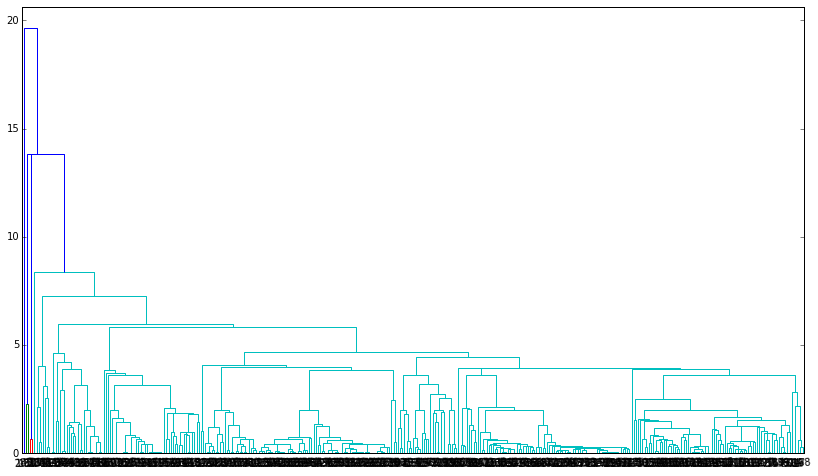

In [179]:
from scipy.cluster.hierarchy import dendrogram
figsize(14, 8)
%time out = dendrogram(Z)

In [180]:
from scipy.cluster import hierarchy
fcluster = hierarchy.fcluster(Z, 4.0, criterion='distance')
print fcluster.shape, np.min(fcluster), np.max(fcluster)

(361,) 1 14


In [176]:
# Approach 2: Use K-means

from scipy.cluster import vq

y = vq.whiten(straight_np)
codebook, distortion = vq.kmeans(y, 20)
print len(codebook), distortion
fcluster, _ = vq.vq(y, codebook)

20 1.6973658663


In [181]:
cid_to_clu = pd.Series(fcluster, index=straight.index, name='cluster')
cid_to_clu.sort()
cid_to_clu = cid_to_clu.reset_index()
cid_to_clu.cluster.value_counts()

12    160
10     89
8      45
11     28
7      20
4       4
3       3
9       2
6       2
5       2
2       2
1       2
14      1
13      1
dtype: int64

In [150]:
fcluster_str = ["straight_clu_{}".format(clu) for clu in fcluster]
cid_to_clu_str = pd.Series(fcluster_str, index=straight.index, name='cluster')
cid_to_clu_str = cid_to_clu_str.reset_index()
cid_to_clu_str.to_csv("clu_straight.csv", index=False)

In [112]:
# Approach 3: PCA with 2 components, to plot and see if there are any obvious clusters.

from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
%time pca.fit(straight_np)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.1 ms


PCA(copy=True, n_components=2, whiten=True)

In [113]:
pca.explained_variance_ratio_

array([ 0.67927172,  0.17201545])

(361, 2)


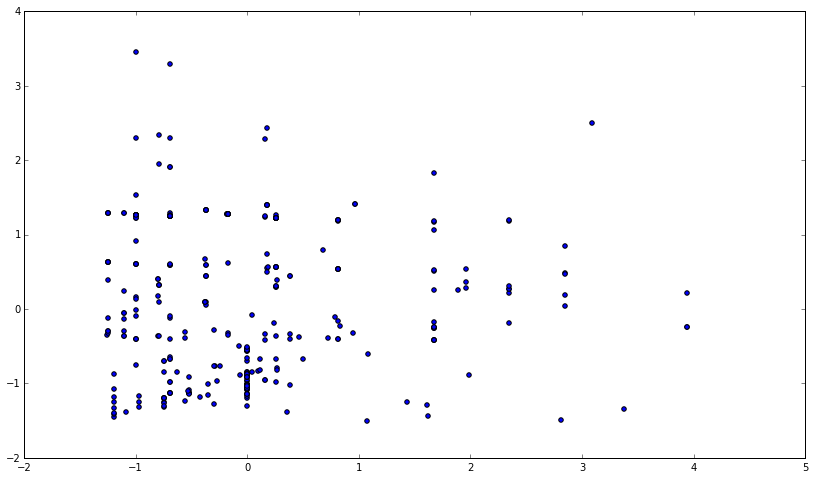

In [116]:
pts = pca.transform(straight_np)
print pts.shape
scatter(pts[:, 0], pts[:, 1])

In [218]:
# Approach 4: map infrequent components to more frequent substitutes.

from scipy.spatial.distance import euclidean

#freq_cids = [
#    'C-1739', 'C-1203', 'C-0244', 'C-0275', 'C-1555', 'C-1344',
#    'C-1615', 'C-1750', 'C-1373']

#freq_cids = [
#    'C-1739', 'C-1203', 'C-0244', 'C-0275', 'C-1555', 'C-1344',
#    'C-1615', 'C-1750', 'C-1373', 'C-1670', 'C-0808', 'C-0703',
#    'C-0170', 'C-1449', 'C-1352', 'C-1545', 'C-0679', 'C-1430',
#    'C-0250', 'C-0618', 'C-1354', 'C-1614', 'C-2022', 'C-0122',
#    'C-2019', 'C-0434']

freq_cids = ['C-1739', 'C-1203', 'C-0244', 'C-0275', 'C-1555', 'C-1344',
       'C-1615', 'C-1750', 'C-1373', 'C-1670', 'C-0808', 'C-0703',
       'C-0170', 'C-1449', 'C-1352', 'C-1545', 'C-0679', 'C-1430',
       'C-0250', 'C-0618', 'C-1354', 'C-1614', 'C-2022', 'C-0122',
       'C-2019', 'C-0434', 'C-1901', 'C-0846', 'C-1343', 'C-2043',
       'C-1711', 'C-1947', 'C-1881', 'C-0829', 'C-0247', 'C-1768',
       'C-0485', 'C-0423', 'C-1843', 'C-1749', 'C-1740', 'C-1242',
       'C-1719', 'C-0162', 'C-1893', 'C-1943', 'C-1412', 'C-0292',
       'C-1678', 'C-1534', 'C-0568', 'C-1792', 'C-0172', 'C-1956',
       'C-2023', 'C-1811', 'C-2021', 'C-0734', 'C-1235', 'C-1880',
       'C-2017', 'C-1005']

all_cids = list(straight.index)

straight_np_wh = vq.whiten(straight_np)

freq_cid_vecs = []
for cid in freq_cids:
    row_idx = all_cids.index(cid)
    assert row_idx != -1
    row = straight_np_wh[row_idx, :]
    freq_cid_vecs.append(row)

cid_to_freq_cid = {}
cid_to_dist = {}
for row_idx, cid in enumerate(straight.index.values):
    if cid in freq_cids:
        cid_to_freq_cid[cid] = cid
        cid_to_dist[cid] = 0.0
        print "cid {} is frequent enough".format(cid)
    else:
        best_i = None
        best_dist = np.inf
        for i in xrange(len(freq_cids)):
            row = straight_np_wh[row_idx, :]
            dist = euclidean(row, freq_cid_vecs[i])
            if dist < best_dist:
                best_dist = dist
                best_i = i
        cid_to_freq_cid[cid] = freq_cids[best_i]
        cid_to_dist[cid] = best_dist
        print "cid {} mapped to freq_cid {} with dist {}".format(cid, freq_cids[best_i], best_dist)

cid C-0012 mapped to freq_cid C-1768 with dist 0.00572083395993
cid C-0014 mapped to freq_cid C-1768 with dist 2.48103262195
cid C-0015 mapped to freq_cid C-1768 with dist 2.01303649676
cid C-0019 mapped to freq_cid C-2021 with dist 0.165916168176
cid C-0029 mapped to freq_cid C-1792 with dist 3.84755369882
cid C-0036 mapped to freq_cid C-1412 with dist 2.08913613284
cid C-0038 mapped to freq_cid C-1373 with dist 0.34580193603
cid C-0046 mapped to freq_cid C-2017 with dist 13.8679358888
cid C-0062 mapped to freq_cid C-1811 with dist 1.86693052278
cid C-0079 mapped to freq_cid C-0568 with dist 3.28931616597
cid C-0080 mapped to freq_cid C-1430 with dist 0.292100966583
cid C-0081 mapped to freq_cid C-1956 with dist 0.167002277025
cid C-0086 mapped to freq_cid C-1430 with dist 0.830196206164
cid C-0093 mapped to freq_cid C-1430 with dist 0.83015620797
cid C-0110 mapped to freq_cid C-0568 with dist 0.873807514456
cid C-0115 mapped to freq_cid C-1430 with dist 0.524291252267
cid C-0122 is f

In [193]:
# A good substitute:
cids = ['C-0122', 'C-1344']
straight[straight.index.isin(cids)]

,bolt_pattern_long,bolt_pattern_wide,head_diameter,overall_length,thickness,groove,unique_feature,orientation,weight,MJ-001,MJ-002,MJ-003,MJ-007,MJ-other,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,bolt_pattern_long_missing,bolt_pattern_wide_missing,head_diameter_missing,overall_length_missing,weight_missing
component_id,,,,,,,,,,,,,,,,,,,,,,,,,,
C-0122,71.77567,40.841225,44.45,19.05,8,True,False,False,0.080,0,0,0,0,1,0,0,0,0,0,1,0,True,True,False,False,False
C-1344,71.77567,40.841225,44.45,19.05,8,True,False,False,0.136,0,0,0,0,1,0,0,0,0,0,1,0,True,True,False,False,False


In [205]:
# A crappy substitute:
cids = ['C-2023', 'C-2019']
straight[straight.index.isin(cids)]

,bolt_pattern_long,bolt_pattern_wide,head_diameter,overall_length,thickness,groove,unique_feature,orientation,weight,MJ-001,MJ-002,MJ-003,MJ-007,MJ-other,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,bolt_pattern_long_missing,bolt_pattern_wide_missing,head_diameter_missing,overall_length_missing,weight_missing
component_id,,,,,,,,,,,,,,,,,,,,,,,,,,
C-2019,69.9,35.7,58.414,27.906098,36.5,False,False,True,1.440,0,0,1,0,0,0,1,0,0,0,0,0,False,False,True,True,False
C-2023,88.9,50.8,58.414,27.906098,36.5,True,False,True,1.621,0,0,1,0,0,0,1,0,0,0,0,0,False,False,True,True,False


In [204]:
straight[straight.index.isin(freq_cids)]

,bolt_pattern_long,bolt_pattern_wide,head_diameter,overall_length,thickness,groove,unique_feature,orientation,weight,MJ-001,MJ-002,MJ-003,MJ-007,MJ-other,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,bolt_pattern_long_missing,bolt_pattern_wide_missing,head_diameter_missing,overall_length_missing,weight_missing
component_id,,,,,,,,,,,,,,,,,,,,,,,,,,
C-0122,71.77567,40.841225,44.450,19.050000,8.00,True,False,False,0.080,0,0,0,0,1,0,0,0,0,0,1,0,True,True,False,False,False
C-0170,52.38000,40.841225,58.414,27.906098,16.00,False,False,True,0.090,0,0,0,0,1,0,0,0,1,0,0,0,False,True,True,True,False
C-0244,152.40000,92.100000,58.414,27.906098,19.05,True,False,True,2.127,0,0,0,0,1,0,0,1,0,0,0,0,False,False,True,True,False
C-0250,130.20000,77.800000,58.414,27.906098,28.00,False,False,True,2.460,0,0,0,0,1,0,0,1,0,0,0,0,False,False,True,True,False
C-0275,120.70000,69.900000,58.414,27.906098,36.50,False,False,True,3.268,0,0,0,0,1,0,0,1,0,0,0,0,False,False,True,True,False
C-0434,57.15000,40.841225,58.414,27.906098,9.72,False,False,True,0.191,0,0,0,0,1,0,0,0,1,0,0,0,False,True,True,True,False
C-0618,106.40000,61.900000,58.414,27.906098,15.90,True,False,True,0.955,0,0,0,0,1,0,0,1,0,0,0,0,False,False,True,True,False
C-0679,52.37000,26.190000,58.414,27.906098,32.00,False,False,True,0.474,0,0,0,0,1,0,0,1,0,0,0,0,False,False,True,True,False
C-0703,71.77567,40.841225,41.280,27.906098,14.22,True,False,False,0.150,0,0,0,0,1,0,0,0,0,0,1,0,True,True,False,True,False


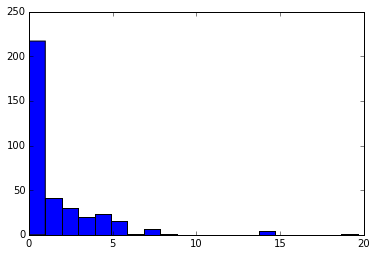

In [219]:
dists = cid_to_dist.values()
hist(dists, bins=20);

In [220]:
df = pd.Series(cid_to_freq_cid, name='cluster')
df.index.name = 'component_id'
df = df.reset_index()
df.to_csv("clu_straight.csv", index=False)